In [1]:
import pickle
import os
import pandas as pd
import numpy as np
from functools import reduce
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
palette_tab10 = sns.color_palette("tab10", 10)

In [2]:
version = 300
saving = ''
certain  = '_certain'

In [3]:
limits = [-20, 20]

In [4]:
foundations = ['harm pos','harm neg','fairness pos','fairness neg','authority pos',
              'authority neg','loyalty pos','loyalty neg', 'purity pos', 'purity neg']
foundation_mapping = {'harm pos':'Care','harm neg':'Harm','fairness pos':'Fairness','fairness neg':'Cheating',
                     'purity pos':'Purity', 'purity neg':'Degradation','authority pos':'Authority',
                     'authority neg':'Subversion','loyalty pos':'Loyalty','loyalty neg':'Betrayal'}

In [5]:
moral_df = pd.read_csv(f'../../data/Survey Data/N{version}/cluster_moralization{saving}{certain}.csv')

In [10]:
moral_df.head()

,identity,foundation,cluster,central sentences,peripheral sentences,central vote,peripheral vote,weighted vote,central foundation vote,weighted foundation vote
0,child,harm pos,0,5,9,Non-moral,Moral,Non-moral,harm,harm
1,child,harm pos,1,9,10,Moral,Moral,Moral,harm,harm
2,child,harm pos,2,1,1,Non-moral,Non-moral,Non-moral,authority,authority
3,child,harm pos,3,1,1,Moral,Moral,Moral,harm,harm
4,child,harm pos,4,9,7,Moral,Non-moral,Non-moral,harm,harm


In [15]:
sum(moral_df[['identity','foundation','cluster']].groupby(['identity','foundation']).count()['cluster'])

103

In [122]:
moral_df.head()

,identity,foundation,cluster,central sentences,peripheral sentences,central vote,peripheral vote,weighted vote,central foundation vote,weighted foundation vote
0,child,harm pos,0,5,9,Non-moral,Moral,Non-moral,harm,harm
1,child,harm pos,1,9,10,Moral,Moral,Moral,harm,harm
2,child,harm pos,2,1,1,Non-moral,Non-moral,Non-moral,authority,authority
3,child,harm pos,3,1,1,Moral,Moral,Moral,harm,harm
4,child,harm pos,4,9,7,Moral,Non-moral,Non-moral,harm,harm


In [123]:
import sys
sys.path.append('../../')
pd.set_option('display.max_colwidth', -1)
categories = ['harm', 'authority', 'fairness', 'loyalty', 'purity']
polarity = ['pos', 'neg']

In [124]:
ages = range(1, 7)

In [125]:
def fix_coords(labels_utterances):
    
    xs = []
    ys = []
    for age,res in labels_utterances.items():
        for row in res:
            pos = row[-1]
            xs.append(pos[0])
            ys.append(pos[1])

    x_min,x_max = np.min(xs) , np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    
    if x_min < limits[0] or x_max > limits[1] or y_min < limits[0] or y_max > limits[1]:
        rate_x = ((x_max - x_min) / (limits[1] - limits[0]))
        rate_y = ((y_max - y_min) / (limits[1] - limits[0]))
        different_x = x_max / ((x_max - x_min) / (limits[1] - limits[0])) - limits[1]
        different_y = y_max / ((y_max - y_min) / (limits[1] - limits[0])) - limits[1]
        xs = (np.array(xs) / rate_x) - different_x
        ys = (np.array(ys) / rate_y) - different_y

    return xs, ys

In [256]:
def get_df(labels_utterances, has_probs = False):
    df = pd.DataFrame()
    columns = ['label', 'context', 'x', 'y']
    labels = []
    context = []
    x = []
    y = []
    max_x = labels_utterances
    for l, d in labels_utterances.items():
        for c , probs, pos in d:

            
            labels.append(str(l))
            context.append(c)
            x.append(pos[0])
            y.append(pos[1])
            if has_probs:
                #TODO
                pass

    df['label'] = labels
    df['context'] = context
    x, y = fix_coords(labels_utterances)
    df['x'] = x
    df['y'] = y
    return df
        
    
        
def find_distance_to_center(center_x, center_y):
    def function(row):
        x = row['x']
        y = row['y']
        center = np.array([center_x, center_y])
        pos = np.array([x, y])
        
        cos_distance = distance.cosine(center, pos)
        
        return cos_distance
    return function




def get_cluster_documents_from_label(df, label,n = 3, l = 10, m = 3):
    '''
    df is a dataframe sorted based on distance to center
    '''
    closest_context = list(set(df.iloc[:n]['context']))
    
    farthest = list(set(df.iloc[-l:]['context']))
    
    random_choices = np.random.choice(len(farthest), min(len(farthest), m), False)
    
    far_context = []
    for random_idx in random_choices:
        context = farthest[random_idx]
        far_context.append(context)

    
    new_df = pd.DataFrame()
    new_df['utterance type'] = ['central'] * len(closest_context) + ['peripheral'] * len(far_context)
    new_df['utterance'] = closest_context + far_context
    new_df['label'] = [label] * len(new_df)
    return new_df


def get_cluster_documents(df,n = 3, l = 10, m = 3):
    labels = df.label.unique()
    all_df = pd.DataFrame()
    for l in labels:
        new_df = df.loc[df.label == l]
        center_x = np.array(new_df['x']).mean()
        center_y = np.array(new_df['y']).mean()
        
        distance_function = find_distance_to_center(center_x, center_y)
        new_df['distance'] = new_df.apply(distance_function, axis = 1)
        new_df = new_df.sort_values(by = 'distance')
        
        all_df = all_df.append(get_cluster_documents_from_label(new_df, label = l))
def get_weighted_foundation(not_cp_moral_df,cluster):
    
    f = list(not_cp_moral_df.loc[not_cp_moral_df.cluster == int(cluster)]['weighted foundation vote'])[0]
    return f
    
   
def get_moral_df(og_df, c, p):
    df = og_df.copy(deep = True)
    cp_moral_df = moral_df.loc[(moral_df.foundation == c + ' ' + p) & (moral_df.identity == identity) & \
                              (moral_df['weighted vote'] == 'Moral') & (moral_df['weighted foundation vote']\
                                                                        == c)]
    not_cp_moral_df = moral_df.loc[(moral_df.foundation == c + ' ' + p) & (moral_df.identity == identity) & \
                              (moral_df['weighted vote'] == 'Moral') & \
                                   (~pd.isna(moral_df['weighted foundation vote'])) & \
                                   (moral_df['weighted foundation vote']!= c)]
    
    
    moral_clusters = cp_moral_df['cluster'].unique()
    if len(moral_clusters) > 0:
         moral_clusters= np.random.choice(cp_moral_df['cluster'].unique(), 1)
    else:
        moral_clusters = [100]

    df1 = df.loc[df.label.astype(int).isin(moral_clusters)]
    df1['foundation'] = [foundation_mapping[c + ' ' + p]] * len(df1)
    df2 = df.loc[df.label.astype(int).isin(not_cp_moral_df['cluster'][:1].unique())]
    df2['foundation'] = [get_weighted_foundation(not_cp_moral_df, c)for c in df2['label']] 
    moral_clusters = \
    list(moral_df.loc[(moral_df.foundation == c + ' ' + p) & (moral_df.identity == identity) ].\
         loc[moral_df['weighted vote'] == 'Moral']['cluster'].unique())
    
    df = df.loc[df.label.astype(int).isin(moral_clusters)]
    df = df1.append(df2)
#     df = df1
    return df

    

    
def plot_clustering(og_df, age, c,p, n = 1, group = 'CS'):
    fig, ax = plt.subplots(figsize = (7, 4))
    df = og_df.copy(deep = True)
    
    for i, foundation in enumerate(foundations):
        f_df = df.loc[df.foundation == foundation]
        if len(f_df) < 1:
            continue
        f_df['foundation'] = [foundation_mapping[x] for x in f_df['foundation']]
#         sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'foundation', ax = ax)
        
        sns.scatterplot(data = f_df , x = 'x', y = 'y', color = palette_tab10[i], 
                        label = foundation_mapping[foundation])

    
    labels = df.label.unique()
    utterance_df = pd.DataFrame()
    for l in df.foundation.unique():
        new_df = df.loc[df.foundation == l]
        center_x = np.array(new_df['x']).mean()
        center_y = np.array(new_df['y']).mean()
        
        distance_function = find_distance_to_center(center_x, center_y)
        new_df['distance'] = new_df.apply(distance_function, axis = 1)
        new_df = new_df.sort_values(by = 'distance')
        n = 0
        closest = new_df.iloc[:n]
        
        for i , row in closest.iterrows():
            x = row['x']
            y = row['y']
            
            ax.text(x, y, row['context'], horizontalalignment='left', size='medium', color='black', weight='semibold')
        new_df = new_df[new_df.context.str.len()<= 60]
        if len(new_df) - n >= 1:
            random_utterance_index = np.random.choice(len(new_df) - n)

            x  = new_df.iloc[random_utterance_index + n]['x']
            y = new_df.iloc[random_utterance_index + n]['y']
            context = new_df.iloc[random_utterance_index + n]['context']
            context = str.replace(context,'CLITIC', '')
            ax.text(x, y,context , horizontalalignment='left',
                    size='x-large', color='black',)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.legend(bbox_to_anchor=(0.5, -0.3), loc='lower center', borderaxespad=0., ncol = len(foundations))
    sns.despine(left=False, bottom=False)
    ax.set_title(f'Moral clusters for {group} aged {age}')
    
    
    


In [257]:
def find_dimension(identity, category, sentiment):
    file_name = f'../../data/dimensionality_reduction/childes_{identity}_{category}_{sentiment}'
    df = pd.read_csv(f"{file_name}.csv")

    for i in range(len(df)):
        if i > 0 and float(df.loc[i - 1]) < 0.95 and float(df.loc[i]) >= 0.95:
            
            return i + 1
    

In [242]:
model_name = 'GMM'
identity = 'child'

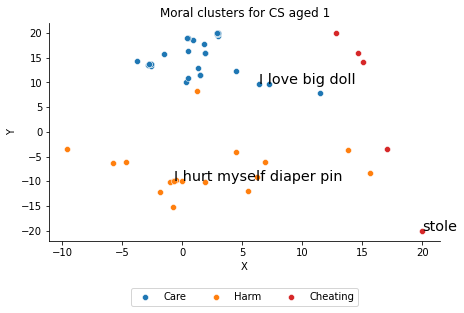

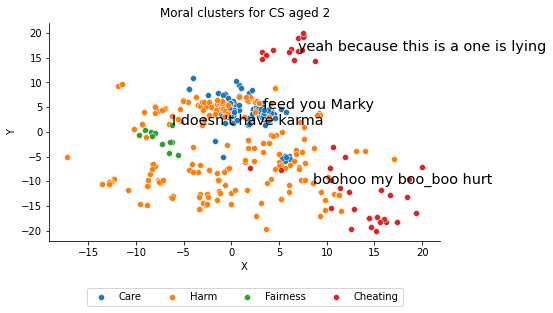

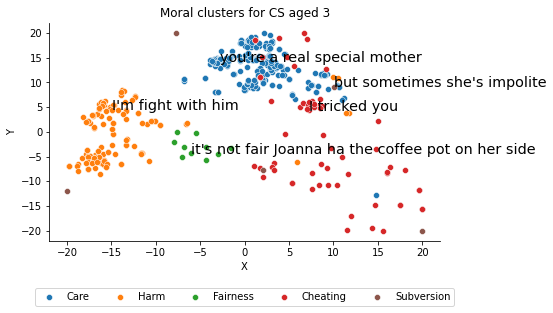

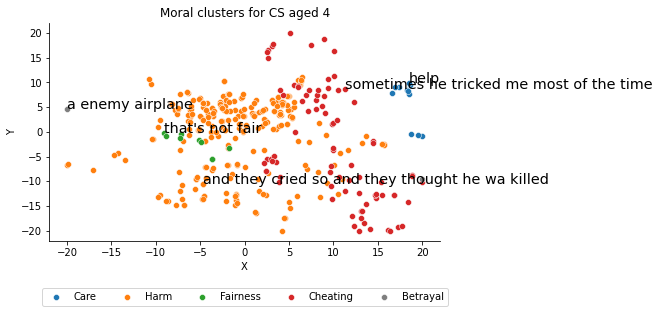

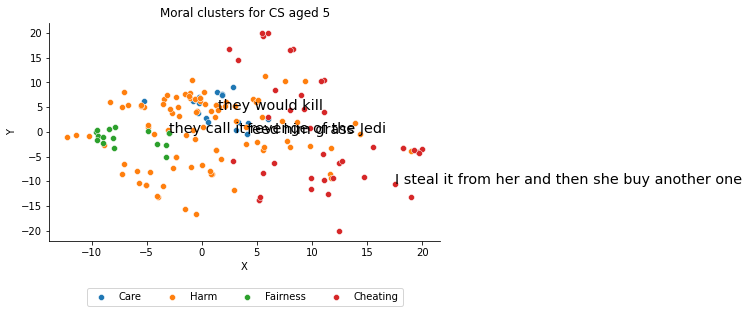

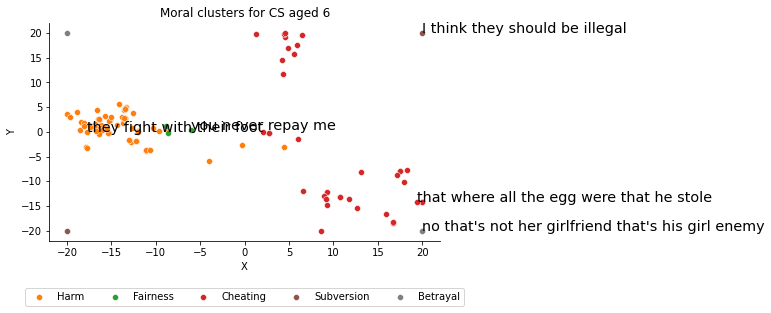

In [245]:
for age in ages:
    all_df = pd.DataFrame()
    for c in categories:
        for p in polarity:
            if c + ' ' + p not in foundations:
                
                continue

            

            model_dir = f'../../data/{model_name}/{identity}/{c}-{p}/{age}_all_dimension_reduced.pkl'

            if not os.path.exists(model_dir):
                continue
            
            dimension = find_dimension(identity, c, p)
            
            labels_utterances, probs, best_k, model = pickle.load(open(model_dir, 'rb'))
            
            df = get_df(labels_utterances)
            df = get_moral_df(df, c ,p)
            df['age'] = [str(age)] * len(df)
            df['foundation'] = [(c + ' ' + p)] * len(df)

            all_df = all_df.append(df)
            

    plot_clustering(all_df, age, c, p,group ='CS')
    plt.savefig(f'../../{identity}_age_{age}_moral_clusters_all.png', bbox_inches = 'tight',dpi = 200)
    plt.show()
    #         get_cluster_documents(all_df)


    

In [246]:
identity = 'parent'

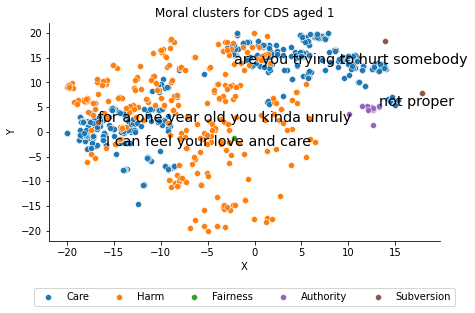

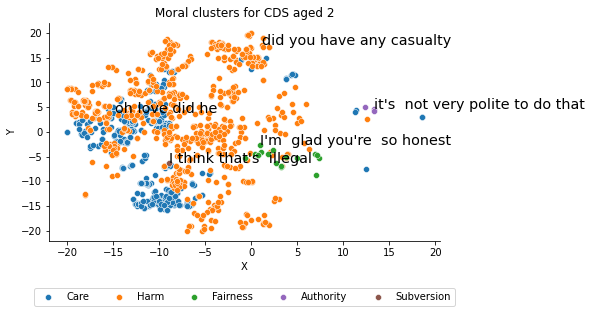

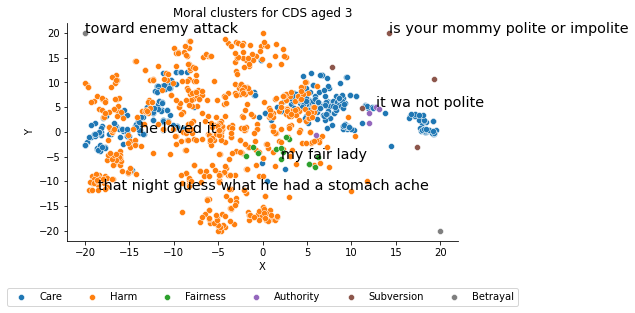

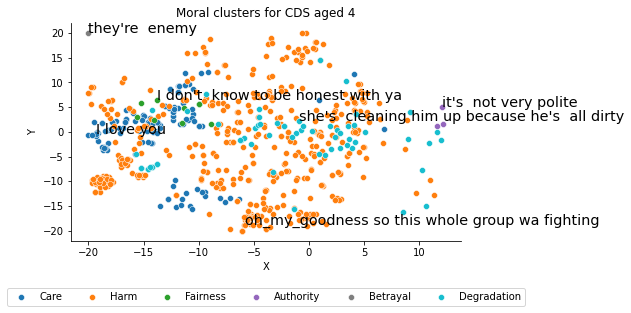

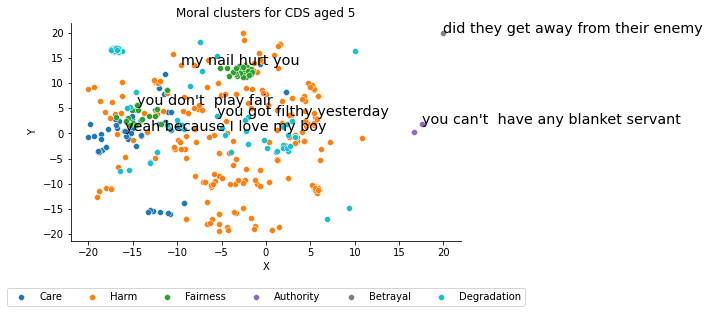

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


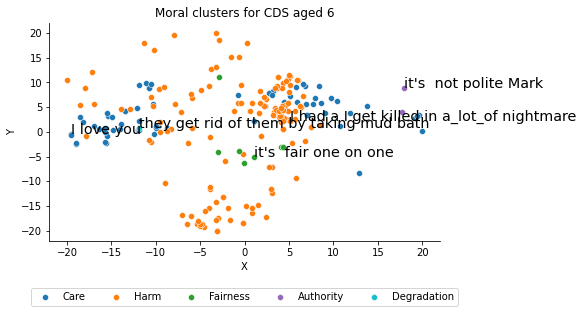

In [266]:
for age in ages:
    all_df = pd.DataFrame()
    for c in categories:
        for p in polarity:
            if c + ' ' + p not in foundations:
                
                continue

            

            model_dir = f'../../data/{model_name}/{identity}/{c}-{p}/{age}_all_dimension_reduced.pkl'

            if not os.path.exists(model_dir):
                continue
            
            dimension = find_dimension(identity, c, p)
            
            labels_utterances, probs, best_k, model = pickle.load(open(model_dir, 'rb'))
            
            df = get_df(labels_utterances)

            df = get_moral_df(df, c ,p)
            
            df['age'] = [str(age)] * len(df)
            df['foundation'] = [(c + ' ' + p)] * len(df)
            

            all_df = all_df.append(df)
            

    plot_clustering(all_df, age, c, p, group = 'CDS')
    plt.savefig(f'../../{identity}_age_{age}_moral_clusters_all.png', bbox_inches = 'tight',dpi = 200)
    plt.show()
    #         get_cluster_documents(all_df)


    
    